In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from math import ceil
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# DATA LOADING

In [2]:
data = []
labels = []
file_name = []
for label_folder in ['Parasitized', 'Uninfected']:
    folder_path = os.path.join('dataset\\', label_folder)
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv.imread(img_path)
        img = cv.resize(img, (100, 100))  # Resize ke ukuran tetap
        data.append(img)
        labels.append(label_folder)
        file_name.append(filename) 

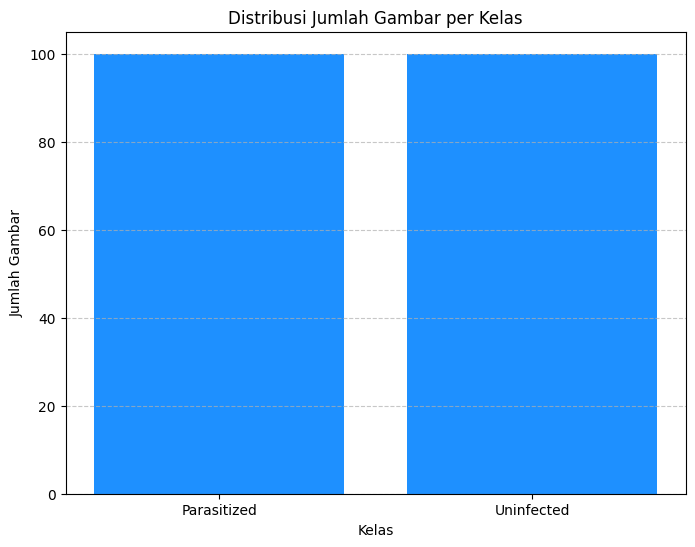

Output: Contoh Sample Data:


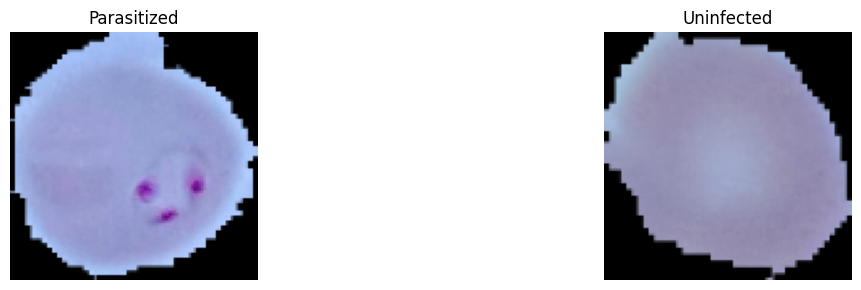

In [3]:
label_counts = Counter(labels)
classes = list(label_counts.keys())
counts = list(label_counts.values())

plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color='dodgerblue')
plt.title("Distribusi Jumlah Gambar per Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Output: Contoh Sample Data:")

plt.figure(figsize=(15, 3))
shown_labels = set()
shown = 0

for i in range(len(data)):
    label = labels[i]
    if label in shown_labels:
        continue
    plt.subplot(1, len(classes), shown + 1)
    plt.imshow(data[i], cmap='gray')
    plt.title(f"{label}")
    plt.axis('off')
    shown_labels.add(label)
    shown += 1
    if shown >= len(classes):
        break

plt.tight_layout()
plt.show()

In [4]:
def prepro1_resize(img, new_width=100, new_height=100):
    old_height, old_width = img.shape[:2]
    resized = np.zeros((new_height, new_width, 3), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(i * old_height / new_height)
            y = int(j * old_width / new_width)
            resized[i, j] = img[x, y]
    return resized
def prepro2_grayscale(img):
    height, width = img.shape[:2]
    gray = np.zeros((height, width), dtype=np.uint8)

    for i in range(height):
        for j in range(width):
            r, g, b = img[i, j]
            gray[i, j] = int(0.2989 * r + 0.5870 * g + 0.1140 * b)  # Luminosity formula
    return gray
def prepro3_normalization(img):
    height, width = img.shape
    norm = np.zeros((height, width), dtype=np.float32)

    for i in range(height):
        for j in range(width):
            norm[i, j] = img[i, j] / 255.0
    return norm


In [5]:
output_folder = 'preprocessed_output1'
os.makedirs(output_folder, exist_ok=True)
dataPreprocessed = []

for i in range(len(data)): 
    img = data[i]

    # === Tahapan Preprocessing Manual ===
    img_resized = prepro1_resize(img)            # Resize manual ke 100x100
    img_grayscale = prepro2_grayscale(img_resized)  # Konversi manual ke grayscale
    img_normalized = prepro3_normalization(img_grayscale)  # Normalisasi manual
    img_uint8 = (img_normalized * 255).astype(np.uint8) # ubah tipe data ke int untuk ekstraksi fitur
    dataPreprocessed.append(img_uint8)
    
    filename = file_name[i]
    save_path = os.path.join(output_folder, filename)
    cv.imwrite(save_path, img_uint8)

# Feature Extraction

In [6]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [7]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [8]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [9]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [10]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [11]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,C33P1thinF_IMG_20150619_114756a_cell_179.png,Parasitized,567.011111,981.059178,552.255051,969.461177,0.534023,0.468131,0.528367,0.479464,...,0.070277,0.063047,0.264675,0.250963,0.265099,0.251091,0.949980,0.912238,0.951339,0.913275
1,C33P1thinF_IMG_20150619_114756a_cell_180.png,Parasitized,482.829495,999.626977,623.916566,939.817570,0.541985,0.479550,0.540982,0.482658,...,0.063445,0.057315,0.254326,0.238493,0.251884,0.239407,0.960143,0.916028,0.948392,0.921052
2,C33P1thinF_IMG_20150619_114756a_cell_181.png,Parasitized,513.236061,891.597898,500.379798,916.151107,0.488824,0.431694,0.494364,0.438714,...,0.046585,0.040369,0.215186,0.201094,0.215834,0.200919,0.943850,0.900317,0.945266,0.897572
3,C33P1thinF_IMG_20150619_114756a_cell_182.png,Parasitized,563.081818,966.057239,642.204545,1095.892358,0.559300,0.513458,0.559587,0.504776,...,0.098408,0.090285,0.314350,0.302430,0.313700,0.300475,0.961647,0.933552,0.956242,0.924621
4,C33P1thinF_IMG_20150619_115740a_cell_161.png,Parasitized,475.507172,828.910927,416.303333,749.968779,0.535679,0.464340,0.544090,0.479750,...,0.067272,0.059704,0.256105,0.243283,0.259368,0.244345,0.954252,0.919163,0.960057,0.926862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,C2NThinF_IMG_20150604_114730_cell_72.png,Uninfected,394.718788,842.800326,530.776566,797.500459,0.697791,0.621574,0.685162,0.631038,...,0.084731,0.076958,0.294141,0.276255,0.291086,0.277413,0.965783,0.925961,0.953958,0.929940
196,C2NThinF_IMG_20150604_114730_cell_98.png,Uninfected,478.829394,791.287726,466.864444,853.869299,0.678717,0.613056,0.657718,0.602215,...,0.102515,0.093720,0.319633,0.307146,0.320180,0.306136,0.958830,0.931347,0.959901,0.925918
197,C2NThinF_IMG_20150604_114751_cell_38.png,Uninfected,401.668182,698.697378,382.034747,665.819508,0.658870,0.576827,0.645972,0.589385,...,0.062527,0.056047,0.251230,0.235841,0.250053,0.236742,0.960785,0.930606,0.962711,0.933872
198,C2NThinF_IMG_20150604_114751_cell_69.png,Uninfected,380.830808,647.748393,403.102121,692.100194,0.676672,0.610119,0.675194,0.596021,...,0.056798,0.050158,0.239709,0.224912,0.238323,0.223960,0.962814,0.935562,0.960628,0.931150


# Feature Selection

In [12]:
# Standardize the features
x_new = hasilEkstrak.drop(columns=['Label', 'Filename'])
y = hasilEkstrak['Label']
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_new)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
x_pca = pca.fit_transform(x_scaled)

# Display the explained variance ratio
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print("Number of Components:", pca.n_components_)

# Create a DataFrame for the PCA-transformed features
pca_features = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(pca.n_components_)])
pca_features['Label'] = y
pca_features.head()

Explained Variance Ratio: [0.50175576 0.30685553 0.10276079 0.03538285 0.02790406]
Number of Components: 5


,PC1,PC2,PC3,PC4,PC5,Label
0,-4.862000,6.065060,-0.268912,0.191285,1.600135,Parasitized
1,-3.636370,5.175361,-1.165399,-1.693403,2.272675,Parasitized
2,-7.707283,5.061549,-0.239925,-0.155913,-0.014772,Parasitized
3,-1.215309,6.258140,-0.260185,-0.536809,3.134470,Parasitized
4,-3.864496,2.725578,0.867307,1.178735,1.224903,Parasitized


In [13]:
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(160, 28)
(40, 28)


In [14]:
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)

# Normalisasi data train dan test dengan Z-score
X_train = (X_train - mean_train) / std_train
X_test = (X_test - mean_train) / std_train

In [15]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

In [16]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.99      0.96      0.97        79
  Uninfected       0.96      0.99      0.98        81

    accuracy                           0.97       160
   macro avg       0.98      0.97      0.97       160
weighted avg       0.98      0.97      0.97       160

[[76  3]
 [ 1 80]]
Accuracy: 0.975

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.88      0.67      0.76        21
  Uninfected       0.71      0.89      0.79        19

    accuracy                           0.78        40
   macro avg       0.79      0.78      0.77        40
weighted avg       0.80      0.78      0.77        40

[[14  7]
 [ 2 17]]
Accuracy: 0.775


In [17]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.99      0.94      0.96        79
  Uninfected       0.94      0.99      0.96        81

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

[[74  5]
 [ 1 80]]
Accuracy: 0.9625

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.90      0.90      0.90        21
  Uninfected       0.89      0.89      0.89        19

    accuracy                           0.90        40
   macro avg       0.90      0.90      0.90        40
weighted avg       0.90      0.90      0.90        40

[[19  2]
 [ 2 17]]
Accuracy: 0.9


In [18]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

 Parasitized       0.96      0.91      0.94        79
  Uninfected       0.92      0.96      0.94        81

    accuracy                           0.94       160
   macro avg       0.94      0.94      0.94       160
weighted avg       0.94      0.94      0.94       160

[[72  7]
 [ 3 78]]
Accuracy: 0.9375

------Testing Set------
              precision    recall  f1-score   support

 Parasitized       0.89      0.76      0.82        21
  Uninfected       0.77      0.89      0.83        19

    accuracy                           0.82        40
   macro avg       0.83      0.83      0.82        40
weighted avg       0.83      0.82      0.82        40

[[16  5]
 [ 2 17]]
Accuracy: 0.825


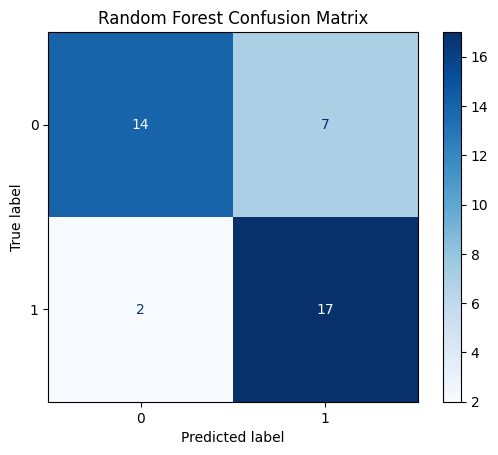

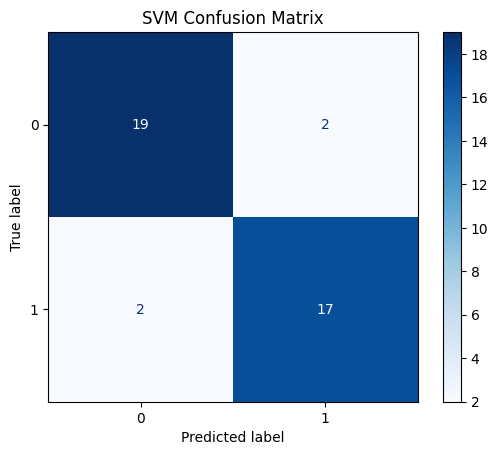

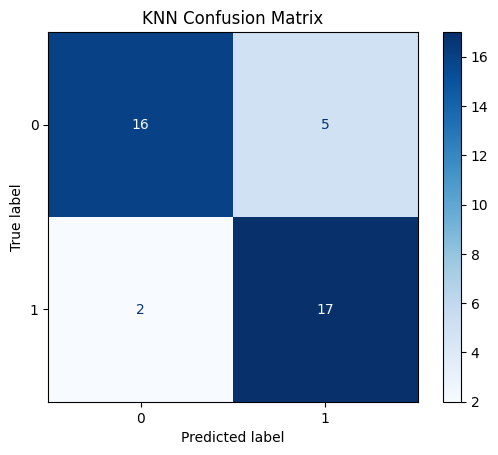

In [19]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")